In [1]:
import numpy as np
import sympy as sp

import matplotlib
import matplotlib.pyplot as plt 
matplotlib.use('Agg')

from sympy import Matrix, init_printing

import qiskit
from qiskit import *

# Representing Data
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_bloch_multivector

# Monitor Job on Real Machine
from qiskit.tools.monitor import job_monitor

from functools import reduce # perform sucessive tensor product

# Calculating cost
from sklearn.metrics import mean_squared_error

# Generating random unitary matrix
from scipy.stats import unitary_group

# Measure run time
import time

# Almost Equal
from numpy.testing import assert_almost_equal as aae

In [2]:
# Matrices
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
H = 1/np.sqrt(2)*np.array([[1, 1], [1, -1]])

CX = np.array([[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0]])

# Eigenvectors of Pauli Matrices
zero = np.array([[1], [0]]) # Z plus basis state
one = np.array([[0], [1]]) # Z plus basis state

plus = np.array([[1], [1]])/np.sqrt(2) # X plus basis state
minus = np.array([[1], [-1]])/np.sqrt(2) # X minus basis state

up = np.array([[1], [1j]])/np.sqrt(2) # Y plus basis state
down = np.array([[1], [-1j]])/np.sqrt(2) # Y plus basis state

# Bell States
B00 = np.array([[1], [0], [0], [1]])/np.sqrt(2) # Bell of 00
B01 = np.array([[1], [0], [0], [-1]])/np.sqrt(2) # Bell of 01
B10 = np.array([[0], [1], [1], [0]])/np.sqrt(2) # Bell of 10
B11 = np.array([[0], [-1], [1], [0]])/np.sqrt(2) # Bell of 11

# Rn Matrix Function
Rx = lambda theta: np.array([[np.cos(theta/2), -1j*np.sin(theta/2)], [-1j*np.sin(theta/2), np.cos(theta/2)]])
Ry = lambda theta: np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]])
Rz = lambda theta: np.array([[np.exp(-1j*theta/2), 0], [0, np.exp(1j*theta/2)]])

# Tensor Product of 2+ matrices/ vectors
tensor = lambda *initial_state: reduce(lambda x, y: np.kron(x, y), initial_state)

In [3]:
def cx_matrix(no_qubits, control, target):
    
    """
    Manually build the unitary matrix for non-adjacent CX gates
    
    Parameters:
    -----------
    no_qubits: int
        Number of qubits in the circuit
    control: int
        Index of the control qubit (1st qubit is index 0)
    target: int
        Index of the target qubit (1st qubit is index 0)
        
    Returns:
    --------
    cx_out:
        Unitary matrix for non-adjacent CX gate
    """

    
    left = [I]*no_qubits
    right = [I]*no_qubits

    left[control] = np.dot(zero, zero.T)
    right[control] = np.dot(one, one.T)

    right[target] = X
    
    cx_out = tensor(*left) + tensor(*right)
          
    return cx_out

In [4]:
def view(mat):
    display(Matrix(mat))

In [5]:
def get(circ, types = 'unitary', nice = True):
    
    """
    This function return the statevector or the unitary of the inputted circuit
    
    Parameters:
    -----------
    circ: QuantumCircuit
        Inputted circuit without measurement gate
    types: str ('unitary')
        Get 'unitary' or 'statevector' option
    nice: bool
        Display the result nicely option or just return unitary/statevector as ndarray
        
    Returns:
    --------
    out: ndarray
        Outputted unitary of statevector
        
    """
    
    if types == 'statevector':
        backend = BasicAer.get_backend('statevector_simulator')
        out = execute(circ, backend).result().get_statevector()
    else: 
        backend = BasicAer.get_backend('unitary_simulator')
        out = execute(circ, backend).result().get_unitary()
        
    if nice:
        display(Matrix(np.round(out, 10))) 
    else:
        return out

In [6]:
def milk(circ):
    return circ.draw(output = 'mpl', reverse_bits='false')

In [7]:
to_list = lambda array: list(np.squeeze(array))


In [8]:
def sim(circ, visual = 'hist'):
    
    """
    Displaying output of quantum circuit
    
    Parameters:
    -----------
    circ: QuantumCircuit
        QuantumCircuit with or without measurement gates
    visual: str ('hist')
        'hist' (counts on histogram) or 'bloch' (statevectors on Bloch sphere) or None (get counts only)
        
    Returns:
    --------
    counts: dict
        Counts of each CBS state
    """
    
    # Simulate circuit and display counts on a histogram
    if visual == 'hist':
        simulator = Aer.get_backend('qasm_simulator')
        results = execute(circ, simulator).result()
        counts = results.get_counts(circ)
        plot_histogram(counts)
        
        return counts
        
    # Get the statevector and display on a Bloch sphere
    elif visual == 'bloch':
        backend = BasicAer.get_backend('statevector_simulator')
        statevector = execute(circ, backend).result().get_statevector()
        get(circ)
        plot_bloch_multivector(statevector)
        
    # Just get counts
    else:
        simulator = Aer.get_backend('qasm_simulator')
        results = execute(circ, simulator).result()
        counts = results.get_counts(circ)
        
        return counts

In [9]:
# j = 1 

# Importing the qiskit module
from qiskit import *

# Defining input, output and scratch qubits
x = 4   # number of input qubits
y1 = 1    # number of output qubit 
s1 = 1   # number of scratch qubit

# Defining Quantum Circuit with the given circuits
def Circuit_1(In,Ou,Sc):
    if Sc != 0:
        # initiating required qubits
        X = QuantumRegister(In, 'input') 
        Y = QuantumRegister(Ou, 'output') 
        S = QuantumRegister(Sc, 'scratch')  
        
        # creating circuit with above qubits
        Circ = QuantumCircuit(X,Y,S)
    else:
        
        # initiating required qubits
        X = QuantumRegister(In, 'input') 
        Y= QuantumRegister(Ou, 'output') 
        
        # creating circuit with above qubits
        Circ = QuantumCircuit(X,Y)
    
    ##### Create you circuit below #########
    

    
    ########################################
    
    # Uncomment to draw quantum circuit
#     display(Circ.draw('mpl'))
    
    # Transpiling the circuit into u, cnot
    Circ = transpile(Circ, basis_gates=['u3','cx'])
    
    # Uncomment to draw transpiled circuit
#     display(Circ.draw('mpl'))
    
    return Circ

qc_1a = Circuit_1(x,y1,s1)

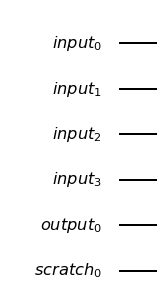

In [10]:
In = 4   # number of input qubits
Ou = 1    # number of output qubit 
Sc = 1
if Sc != 0:
    # initiating required qubits
    X = QuantumRegister(In, 'input') 
    Y = QuantumRegister(Ou, 'output') 
    S = QuantumRegister(Sc, 'scratch')  

    # creating circuit with above qubits
    Circ = QuantumCircuit(X,Y,S)
else:

    # initiating required qubits
    X = QuantumRegister(In, 'input') 
    Y= QuantumRegister(Ou, 'output') 

    # creating circuit with above qubits
    Circ = QuantumCircuit(X,Y)

##### Create you circuit below #########



########################################

# Uncomment to draw quantum circuit
#     display(Circ.draw('mpl'))

# Transpiling the circuit into u, cnot

# Uncomment to draw transpiled circuit
Circ.draw('mpl')

In [11]:
def opium(n):

    def popcount(x):
        poppy = 0
        res = [int(x) for x in str(x)]
        for i in range(len(str(x))):
            if res[i] != 0:
                poppy+=1
        return poppy

    for num in range(2**n):

        a = bin(num)[2:].zfill(n)
        popcount1 = popcount(int(bin(num)[2:]))



        f_x = bin(popcount1)[2:].zfill(n-1)

        num = str(num).zfill(2)

        print(f'{num}| {a} | {f_x}')

opium(1024)

00| 0000000000 | 000000000
01| 0000000001 | 000000001
02| 0000000010 | 000000001
03| 0000000011 | 000000010
04| 0000000100 | 000000001
05| 0000000101 | 000000010
06| 0000000110 | 000000010
07| 0000000111 | 000000011
08| 0000001000 | 000000001
09| 0000001001 | 000000010
10| 0000001010 | 000000010
11| 0000001011 | 000000011
12| 0000001100 | 000000010
13| 0000001101 | 000000011
14| 0000001110 | 000000011
15| 0000001111 | 000000100
16| 0000010000 | 000000001
17| 0000010001 | 000000010
18| 0000010010 | 000000010
19| 0000010011 | 000000011
20| 0000010100 | 000000010
21| 0000010101 | 000000011
22| 0000010110 | 000000011
23| 0000010111 | 000000100
24| 0000011000 | 000000010
25| 0000011001 | 000000011
26| 0000011010 | 000000011
27| 0000011011 | 000000100
28| 0000011100 | 000000011
29| 0000011101 | 000000100
30| 0000011110 | 000000100
31| 0000011111 | 000000101
32| 0000100000 | 000000001
33| 0000100001 | 000000010
34| 0000100010 | 000000010
35| 0000100011 | 000000011
36| 0000100100 | 000000010
3

500| 0111110100 | 000000110
501| 0111110101 | 000000111
502| 0111110110 | 000000111
503| 0111110111 | 000001000
504| 0111111000 | 000000110
505| 0111111001 | 000000111
506| 0111111010 | 000000111
507| 0111111011 | 000001000
508| 0111111100 | 000000111
509| 0111111101 | 000001000
510| 0111111110 | 000001000
511| 0111111111 | 000001001
512| 1000000000 | 000000001
513| 1000000001 | 000000010
514| 1000000010 | 000000010
515| 1000000011 | 000000011
516| 1000000100 | 000000010
517| 1000000101 | 000000011
518| 1000000110 | 000000011
519| 1000000111 | 000000100
520| 1000001000 | 000000010
521| 1000001001 | 000000011
522| 1000001010 | 000000011
523| 1000001011 | 000000100
524| 1000001100 | 000000011
525| 1000001101 | 000000100
526| 1000001110 | 000000100
527| 1000001111 | 000000101
528| 1000010000 | 000000010
529| 1000010001 | 000000011
530| 1000010010 | 000000011
531| 1000010011 | 000000100
532| 1000010100 | 000000011
533| 1000010101 | 000000100
534| 1000010110 | 000000100
535| 1000010111 | 00

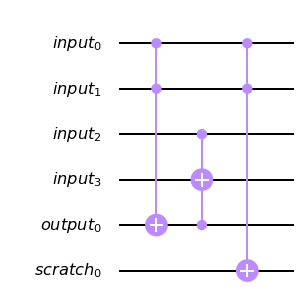

In [22]:
In = 4   # number of input qubits
Ou = 1    # number of output qubit 
Sc = 1
if Sc != 0:
    # initiating required qubits
    X = QuantumRegister(In, 'input') 
    Y = QuantumRegister(Ou, 'output') 
    S = QuantumRegister(Sc, 'scratch')  

    # creating circuit with above qubits
    Circ = QuantumCircuit(X,Y,S)
else:

    # initiating required qubits
    X = QuantumRegister(In, 'input') 
    Y= QuantumRegister(Ou, 'output') 

    # creating circuit with above qubits
    Circ = QuantumCircuit(X,Y)

##### Create you circuit below #########

Circ.ccx(0,1,4)
Circ.ccx(2,4,3)
Circ.ccx(0,1,5)


########################################

# Uncomment to draw quantum circuit
#     display(Circ.draw('mpl'))

# Transpiling the circuit into u, cnot

# Uncomment to draw transpiled circuit
Circ.draw('mpl')